# Analyzing Time-series Data with FTGPs

We use time-series decomposition to try to explain/analyze the quality of our FTGPs. Time-series decomposition helps us break down a time-series dataset into three main components:

**1. Trend:** The trend component represents the long-term movement in the data, representing the underlying pattern.

**2. Seasonality:** The seasonality component represents the repeating, short-term fluctuations caused by factors like seasons or cycles.

**3. Residual (Noise):** The residual component represents random variability that remains after removing the trend and seasonality.

By separating these components, we can gain insights into the behavior of the data and make better forecasts. 

## Types of Time Series Decomposition Techniques

### a) Additive Decomposition

* In additive decomposition, the time series is expressed as the sum of its components. It’s suitable when the magnitude of seasonality doesn’t vary with the magnitude of the time series.

$$Y(t) = Trend(t) + Seasonal(t) + Residual(t)$$

### b) Multiplicative Decomposition

* In multiplicative decomposition, the time series is expressed as the product of its components.It’s suitable when the magnitude of seasonality scales with the magnitude of the time series.

$$Y(t) = Trend(t) * Seasonal(t) * Residual(t)$$

## Methods of Decomposition
### a) Moving Averages

* Moving averages involve calculating the average of a certain number of past data points. It helps smooth out fluctuations and highlight trends.

### b) Seasonal Decomposition of Time Series

* The Seasonal and Trend decomposition using Loess (STL) is a popular method for decomposition, which uses a combination of local regression (Loess) to extract the trend and seasonality components.

### c) Exponential Smoothing State Space Model

* This method involves using the ETS framework to estimate the trend and seasonal components in a time series.

## Reference
* https://www.geeksforgeeks.org/time-series-decomposition-techniques/


## Import Libraries

In [55]:
import numpy as np
import pandas as pd
import so4gp as sgp
import matplotlib.pyplot as plt
from numpy.linalg import norm
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Import from local directory
import sys

sys.path.insert(0, '../src')
from TemporalGP.TGP.tgrad_ami import TGradAMI
from TemporalGP.TGP.t_graank import TGrad

In [56]:
# Hyperparameters

# f_path = "../datasets/air_quality1k.csv"
eq = False
min_sup = 0.5
tgt_col = 2
min_rep = 0.5
num_cores = 4

f_path = "aqy1k_transformed_data.csv"

In [3]:
data = pd.read_csv(f_path)
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,2.6,1292,112,9.4,955,103,1174,92,1559,972,18.5,65.2,1.0411
1,3/10/2004,19:00:00,2.0,1402,88,9.0,939,131,1140,114,1555,1074,21.0,58.9,1.0746
2,3/10/2004,20:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,21.3,59.5,0.9974
3,3/10/2004,21:00:00,2.2,1272,51,6.5,836,131,1205,116,1490,1110,21.3,57.7,0.8997
4,3/10/2004,22:00:00,1.6,1197,38,4.7,750,89,1337,96,1393,949,21.3,56.1,0.9087


In [4]:
tgp = TGradAMI(f_path, eq, min_sup, tgt_col, min_rep, num_cores)
# tgp.full_attr_data

Dataset Ok


In [5]:
data_gp = TGradAMI.process_time(tgp.data)
new_data = data_gp.data
data_df = pd.DataFrame(data=new_data[1:, :], columns=new_data[0, :])
data_df

,2808997200.0,2,1402,88,9.0,939,131,1140,114,1555,1074,21.0,58.9,1.0746
0,2809000800.0,2.2,1376,80,9.2,948,172,1092,122,1584,1203,21.3,59.5,0.9974
1,2809004400.0,2.2,1272,51,6.5,836,131,1205,116,1490,1110,21.3,57.7,0.8997
2,2809008000.0,1.6,1197,38,4.7,750,89,1337,96,1393,949,21.3,56.1,0.9087
3,2809011600.0,1.2,1185,31,3.6,690,62,1462,77,1333,733,21.3,58.0,0.8881
4,2809015200.0,1.2,1136,31,3.3,672,62,1453,76,1333,730,20.2,58.4,0.8581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,2810775600.0,2.2,1197,117,6.5,837,144,957,118,1498,965,14.6,66.1,0.9038
494,2810779200.0,1.7,1277,156,7.7,886,140,902,109,1579,1004,14.4,68.9,0.8880
495,2810782800.0,1.9,1430,332,11.3,1025,204,779,123,1772,1166,13.9,45.0,0.8841
496,2810786400.0,2.9,1242,232,9.1,944,149,846,114,1638,991,13.5,30.7,0.9085


In [36]:
datetime_series = pd.to_datetime(new_data[1:, 0].astype(float), unit='s')
datetime_index = pd.DatetimeIndex(datetime_series, freq='h')
#datetime_index

In [40]:
ts_1 = pd.Series(new_data[1:, 1], index=datetime_index)  # CO(GT)
ts_2 = pd.Series(new_data[1:, 5], index=datetime_index)  # NMHC(GT)
ts_3 = pd.Series(new_data[1:, 7], index=datetime_index)  # PT08.S3(NOx)
ts_4 = pd.Series(new_data[1:, 8], index=datetime_index)  # NO2(GT)

ts_n = pd.Series(new_data[1:, 11], index=datetime_index)  # T

In [44]:
demo_path = "../datasets/DATASET.csv"
demo_df = pd.read_csv(demo_path)
demo_df

,Date,exercise_hours,stress_level
0,2018-01-01,1,4
1,2018-01-03,2,2
2,2018-01-05,3,3
3,2018-01-07,1,2
4,2018-01-09,3,3
5,2018-01-10,1,4
6,2018-01-12,2,2
7,2018-01-15,3,3
8,2018-01-16,1,2
9,2018-01-20,3,3


In [59]:
mine_obj = sgp.GRAANK(demo_df, 0.25)
res = mine_obj.discover()
print(res)

{"Algorithm": "GRAANK", "Patterns": [[["exercise_hours+", "stress_level+"], 0.343], [["exercise_hours-", "stress_level-"], 0.343]], "Invalid Count": 2}


In [51]:
s1 = np.array(demo_df["exercise_hours"]).reshape(-1, 1)
s2 = np.array(demo_df["stress_level"]).reshape(-1, 1)

s1.shape

(50, 1)

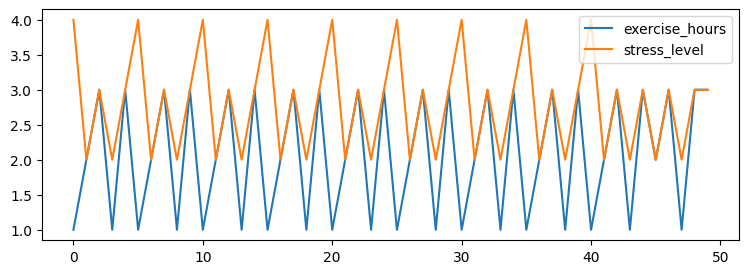

In [53]:
plt.figure(figsize=(9, 3))
plt.plot(s1, label="exercise_hours")
plt.plot(s2, label="stress_level")
plt.legend()
plt.show()

In [52]:
distance, path = fastdtw(s1, s2, dist=euclidean)

print(distance)
print(path)

33.0
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (4, 5), (5, 6), (6, 6), (7, 7), (8, 8), (9, 9), (9, 10), (9, 11), (9, 12), (9, 13), (9, 14), (9, 15), (10, 16), (11, 16), (12, 17), (13, 18), (14, 19), (14, 20), (15, 21), (16, 21), (17, 22), (18, 23), (19, 24), (19, 25), (20, 26), (21, 26), (22, 27), (23, 28), (24, 29), (24, 30), (25, 31), (26, 31), (27, 32), (28, 33), (29, 34), (29, 35), (30, 36), (31, 36), (32, 37), (33, 38), (34, 39), (34, 40), (35, 41), (36, 41), (37, 42), (38, 43), (39, 44), (40, 45), (41, 45), (42, 46), (43, 47), (44, 48), (44, 49), (45, 49), (46, 49), (47, 49), (48, 49), (49, 49)]


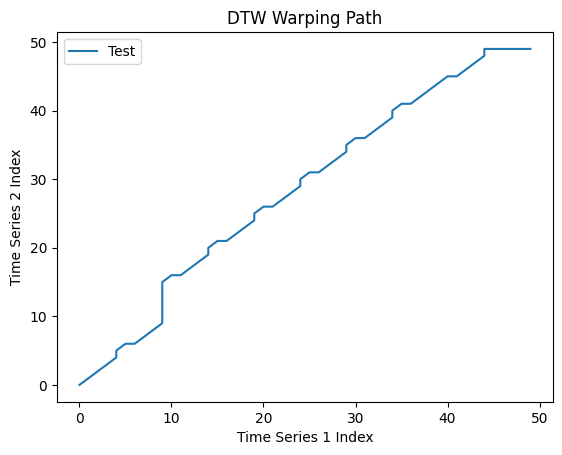

In [60]:
plt.plot([p[0] for p in path], [p[1] for p in path], '-', label="Test")

plt.xlabel('Time Series 1 Index')
plt.ylabel('Time Series 2 Index')
plt.title('DTW Warping Path')
plt.legend()
plt.show()